# QA System with Encoder-Decoder Model using LSTM

In [1]:
import string
import pandas as pd
import numpy as np
from collections import Counter
from tqdm.notebook import tqdm
import requests
from bs4 import BeautifulSoup

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

import spacy
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud

In [2]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## DATA EXTRACTION

### 1. DOWNLOADED SQUAD JSON

In [3]:
# df_json = pd.read_json("train.json")

# def extract_data(data):
#     return data['title'], data['paragraphs'][0]['qas'][0]['question'],data['paragraphs'][0]['qas'][0]['answers'], data['paragraphs'][0]['qas'][0]['is_impossible'], data['paragraphs'][0]['context']

# def return_dataframe(data):
#     d = {'title': [], 'question': [], 'answers':[], 'labels': [], 'context': []}
#     for row in tqdm(data):
#         d['title'].append(row[0])
#         d['question'].append(row[1])
#         if len(row[2]):
#             d['answers'].append(row[2][0]['text'])
#         else:
#             d['answers'].append(np.nan)
#         d['labels'].append(row[3])
#         d['context'].append(row[4])
#     return pd.DataFrame(d)

# data_squad = df_json['data'].apply(extract_data)
# df_squad = return_dataframe(data_squad)

  0%|          | 0/442 [00:00<?, ?it/s]

We had preprocessed SQUAD dataset which we do not choose to use in the project as we have to demonstrate the skills of data scrapping or use unprocessed dataset as per the project requirements.

### 2. IMMIGRATION DATA SCRAPPING

In [4]:
def extract_Immi_QA(n_pages=100):
    data = {'q':[], 'a': []}
    
    with tqdm(total=n_pages, desc="Extracting Data: ") as pbar:
        for counter in range(n_pages):
            res = requests.get(f"https://ircc.canada.ca/english/helpcentre/answer.asp?qnum={counter}")
            soup = BeautifulSoup(res.content, "html.parser")
            q = soup.find("h1", id="wb-cont")
            a = soup.find("div", itemprop="text")
            
            if q:
                q = q.get_text()
            if a:
                a = a.find_all("p")

            data['q'].append(q)
            data['a'].append(a)
            pbar.update(1)
    return data

We tried to extract the immigration question-answering dataset but we only got around 1-2K QA pairs so we didn't proceed with this dataset.

### 3. SQUAD DATA SCRAPPING

In [5]:
def scrape_data(base_url):
    response = requests.get(base_url)
    soup = BeautifulSoup(response.content, "html.parser")

    topics = soup.find("div", class_="infoBody").find("ul").find_all("li")
    base_info = []
    for topic in topics:
        a = topic.find("a")
        if a:
            html = a.get("href").split("/")[-1]
            text = a.get_text()
            base_info.append((text, html))

    data = {'context': [], 'question': [], 'answers': []}
    for info in tqdm(base_info):
        res = requests.get(base_url + info[1])
        sp = BeautifulSoup(res.content, "html.parser")
        rows = sp.find_all("div", class_="row")

        for row in rows:
            if row.find("div", class_="col-md-6"):
                context = row.find("div", class_='col-md-6').find("pre").get_text()
                qalist = row.find("div", class_="qas-wrap").find_all("div", class_="qa-wrap")

                for qa in qalist:
                    question = qa.find("strong", class_="question").get_text()
                    answers = [] 
                    ansTags = qa.find_all("span", class_="answer") 
                    for tag in ansTags:
                        answers.append(tag.get_text())

                    data['context'].append(context)
                    data['question'].append(question)
                    data['answers'].append(answers)
    return pd.DataFrame(data)

base_url = "https://rajpurkar.github.io/SQuAD-explorer/explore/v2.0/dev/"
df1 = scrape_data(base_url)

  0%|          | 0/35 [00:00<?, ?it/s]

We scrapped the raw data from the url given above and performed the necessary exploration and preprocessing with this dataset.

In [6]:
df1.shape

(12285, 3)

The dataset has total observations more than 12K with three features namely context, question and answer. The answers are the list of different possible answers for the given question initially.

In [7]:
df1.head(6)

,context,question,answers
0,The Normans (Norman: Nourmands; French: Norman...,In what country is Normandy located?,"[France, France, France, France]"
1,The Normans (Norman: Nourmands; French: Norman...,When were the Normans in Normandy?,"[10th and 11th centuries, in the 10th and 11th..."
2,The Normans (Norman: Nourmands; French: Norman...,From which countries did the Norse originate?,"[Denmark, Iceland and Norway, Denmark, Iceland..."
3,The Normans (Norman: Nourmands; French: Norman...,Who was the Norse leader?,"[Rollo, Rollo, Rollo, Rollo]"
4,The Normans (Norman: Nourmands; French: Norman...,What century did the Normans first gain their ...,"[10th century, the first half of the 10th cent..."
5,The Normans (Norman: Nourmands; French: Norman...,Who gave their name to Normandy in the 1000's ...,[]


# Exploratory Data Analysis (EDA)

In [8]:
def top_common_words(text, n):
    words = word_tokenize(text.lower())
    words = [word for word in words if word.isalnum() and word not in stopwords.words("english")]
    word_counts = Counter(words)
    
    top_words = word_counts.most_common(n)
    return top_words

In [9]:
# n=10 is passed and 10 most common words are extracted along with their counts

combined_text = ' '.join(df1['question'].astype(str).tolist())
top_words_result = top_common_words(combined_text, n=10)

df_top_words = None
if top_words_result:
    df_top_words = pd.DataFrame(top_words_result, columns=['Word', 'Count'])
df_top_words

,Word,Count
0,many,719
1,year,367
2,type,363
3,name,319
4,used,289
5,rhine,240
6,first,239
7,one,235
8,system,202
9,university,198


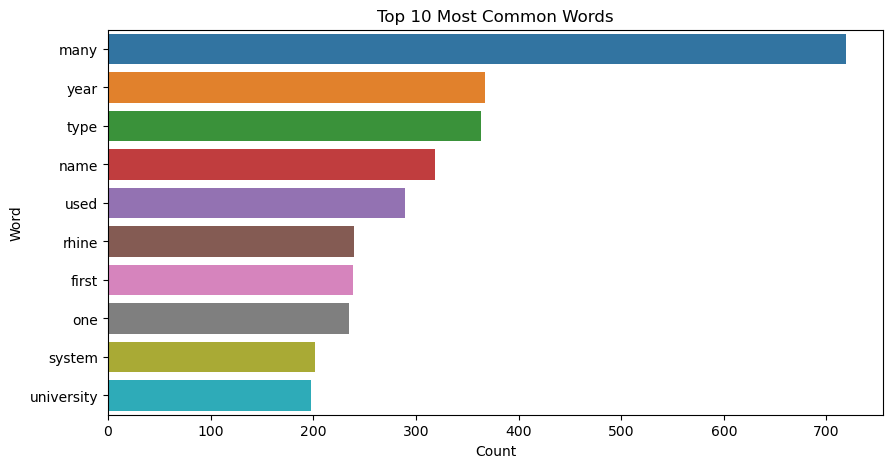

In [10]:
# sns barplot is used to plot the 10 most common words. X axis is count and y is words
plt.figure(figsize=(10, 5))
sns.barplot(x='Count', y='Word', data=df_top_words,)
plt.title('Top 10 Most Common Words')
plt.xlabel('Count')
plt.ylabel('Word')
plt.show()

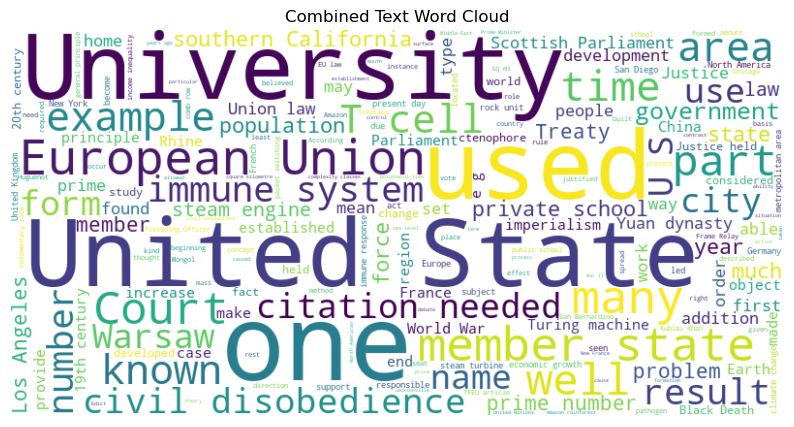

In [11]:
combined_text = ' '.join((df1['context'] + df1['question']).astype(str).tolist())

description_wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, background_color='white').generate(combined_text)
                        
plt.figure(figsize=(10, 7))
plt.imshow(description_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Combined Text Word Cloud')
plt.show()

In [12]:
def top_ngrams(column, n, ngram_range=(1, 1)):
    def process_text(text):
        tokens = word_tokenize(text.lower())
        tokens = [word for word in tokens if word.isalnum() and word not in stopwords.words("english")]
        return ' '.join(tokens)

    processed_texts = column.apply(process_text)

    vectorizer = CountVectorizer(ngram_range=ngram_range)
    X = vectorizer.fit_transform(processed_texts)
    feature_names = vectorizer.get_feature_names_out()
    counts = X.sum(axis=0).A1
    ngram_counts = dict(zip(feature_names, counts))
    sorted_ngrams = sorted(ngram_counts.items(), key=lambda x: x[1], reverse=True)[:n]
    return sorted_ngrams

In [13]:
# Setting n=10(10 n_grams) ngram_range = (2,2) is for biagram and (3,3) for trigram

top_bigrams = top_ngrams(df1['question'], 10, ngram_range=(2, 2))
top_trigrams = top_ngrams(df1['question'], 10, ngram_range=(3, 3))

print("Top Bigrams:")
for bigram in top_bigrams:
    print(bigram)

print("\nTop Trigrams:")
for trigram in top_trigrams:
    print(trigram)

Top Bigrams:
('civil disobedience', 98)
('immune system', 73)
('united states', 66)
('european union', 60)
('southern california', 60)
('many people', 51)
('private schools', 50)
('black death', 44)
('steam engine', 41)
('union law', 40)

Top Trigrams:
('european union law', 33)
('french indian war', 17)
('adaptive immune system', 11)
('sources european union', 11)
('also university alumni', 10)
('health social problems', 10)
('computational complexity theory', 8)
('high school education', 8)
('john paul ii', 8)
('many people lived', 8)


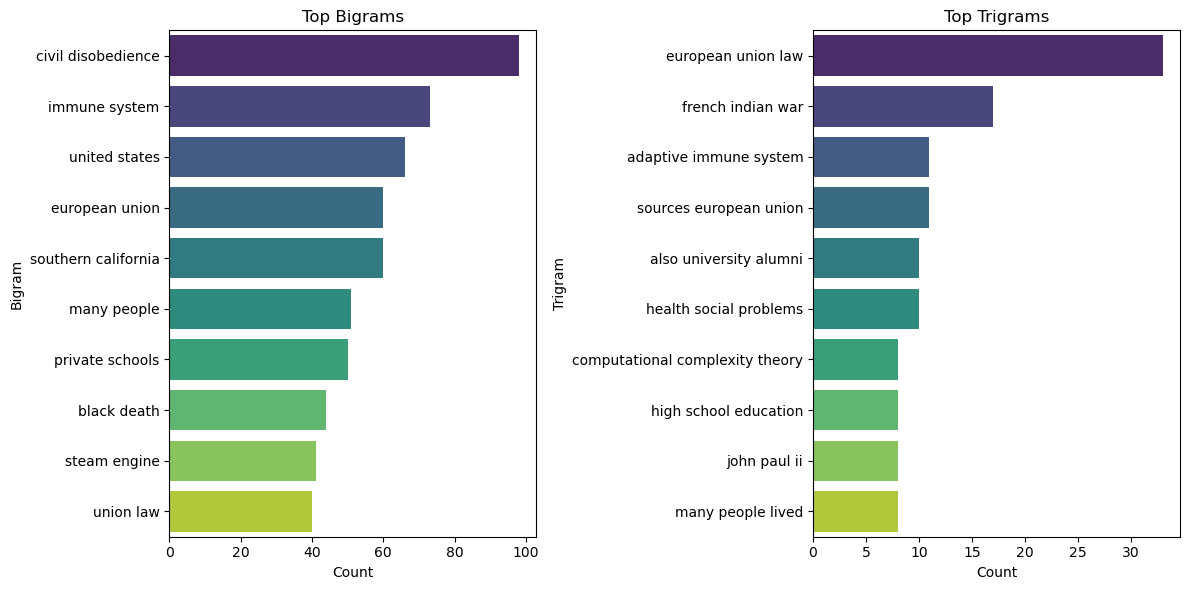

In [14]:
#Creating df1_bigrams and df1_trigrams that contains the top_ngrams and its count

df1_bigrams = pd.DataFrame(top_bigrams, columns=['Bigram', 'Count'])
df1_trigrams = pd.DataFrame(top_trigrams, columns=['Trigram', 'Count'])
plt.figure(figsize=(12, 6))

#Barplot using sns for top bigrams
plt.subplot(1, 2, 1)
sns.barplot(x='Count', y='Bigram', data=df1_bigrams, palette='viridis')
plt.title('Top Bigrams')

#Barplot usisng seaborn for top Trigrams
plt.subplot(1, 2, 2)
sns.barplot(x='Count', y='Trigram', data=df1_trigrams, palette='viridis', )
plt.title('Top Trigrams')

plt.tight_layout()
plt.show()

## DATA CLEANSING

In [15]:
# Create separate samples for each context-question-answer pair
samples = []
for i in tqdm(range(len(df1['context']))):
    context = df1['context'][i]
    question = df1['question'][i]
    answers = df1['answers'][i]

    for answer in set(answers):
        samples.append({'context': context, 'question': question, 'answer': answer})
df = pd.DataFrame(samples)

  0%|          | 0/12285 [00:00<?, ?it/s]

In [16]:
df.head()

,context,question,answer
0,The Normans (Norman: Nourmands; French: Norman...,In what country is Normandy located?,France
1,The Normans (Norman: Nourmands; French: Norman...,When were the Normans in Normandy?,10th and 11th centuries
2,The Normans (Norman: Nourmands; French: Norman...,When were the Normans in Normandy?,in the 10th and 11th centuries
3,The Normans (Norman: Nourmands; French: Norman...,From which countries did the Norse originate?,"Denmark, Iceland and Norway"
4,The Normans (Norman: Nourmands; French: Norman...,Who was the Norse leader?,Rollo


In [17]:
df.shape

(10685, 3)

The total usuable non-null observations are almost 10K in the dataset extracted.

In [18]:
# step 1: Transforming context and question into lowercase
df['context'] = df['context'].str.lower()
df['question'] = df['question'].str.lower()

In [19]:
# Step 2: Tokenization and Lemmatization using spaCy
nlp = spacy.load('en_core_web_sm')

def preprocess_text(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return ' '.join(tokens)

The context and question features are tokenized and lemmatized along with stop words removal and punctuation removal, however, the answer could be case sensitive, may be with punctuation, and so on.

In [20]:
df['context'] = df['context'].apply(preprocess_text)
df['question'] = df['question'].apply(preprocess_text)

In [21]:
# df = pd.read_csv("initial_preprocessed.csv")
# df.drop(['Unnamed: 0'], axis=1, inplace=True)
# df.dropna(inplace=True)

In [22]:
df.head(3)

,context,question,answer
0,normans norman nourmand french normand latin n...,country normandy locate,France
1,normans norman nourmand french normand latin n...,normans normandy,10th and 11th centuries
2,normans norman nourmand french normand latin n...,normans normandy,in the 10th and 11th centuries


In [23]:
# df.to_csv("initial_preprocessed.csv")

## TRAIN-TEST SPLIT

In [24]:
# Split the data into training and testing sets
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

In [25]:
train_data.shape, test_data.shape

((8548, 3), (2137, 3))

The data is divided into training and testing set with ratio of 80 and 20. Total observations in training set are more than 8K and that in testing set are more than 2K.

## DATA PREPROCESSING

### 1. Tokenization and Vocabulary Creation

In [26]:
# Tokenization using TensorFlow Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['context'].tolist() + train_data['question'].tolist())

In [27]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

13891

The size of vocabularly considering context and question column is almost 14K. The answer is not considered while creating vocab because the answer is alreay present within context.

### 2. Sequencing - Text to Sequence Conversion

In [28]:
# Convert text to sequences
train_context_sequences = tokenizer.texts_to_sequences(train_data['context'].tolist())
train_question_sequences = tokenizer.texts_to_sequences(train_data['question'].tolist())
train_answer_sequences = tokenizer.texts_to_sequences(train_data['answer'].tolist())

test_context_sequences = tokenizer.texts_to_sequences(test_data['context'].tolist())
test_question_sequences = tokenizer.texts_to_sequences(test_data['question'].tolist())
test_answer_sequences = tokenizer.texts_to_sequences(test_data['answer'].tolist())

In [29]:
# Pad sequences for consistent length
max_seq_length = max(max(len(seq) for seq in train_context_sequences),
                    max(len(seq) for seq in train_question_sequences))
max_seq_length

373

### 3. Padding Sequences

In [30]:
train_context_padded = pad_sequences(train_context_sequences, maxlen=max_seq_length, padding='post', truncating='post')
train_question_padded = pad_sequences(train_question_sequences, maxlen=max_seq_length, padding='post', truncating='post')
train_answer_padded = pad_sequences(train_answer_sequences, maxlen=max_seq_length, padding='post', truncating='post')

test_context_padded = pad_sequences(test_context_sequences, maxlen=max_seq_length, padding='post', truncating='post')
test_question_padded = pad_sequences(test_question_sequences, maxlen=max_seq_length, padding='post', truncating='post')
test_answer_padded = pad_sequences(test_answer_sequences, maxlen=max_seq_length, padding='post', truncating='post')

In [31]:
train_context_padded[0]

array([ 120,   71,  136, 1220,  922,   12,   39,  199,   62,  380,  952,
        420,  385,   25,  922,   12,   39,  922,   12,  393,  446,  120,
        254, 2767,   39, 1881, 3951, 1425,   50, 2271,  394, 1911, 4302,
       3492,   71,  262, 4302,  465,   51,  755, 1093,   12,  661, 2716,
       4169, 3092,  510, 2673, 3493,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

### 4. Word Embedding using GloVe

In [32]:
glove_file_path = 'glove.6B.100d.txt'

glove_embeddings = {}
total_lines = 0 

# Reopen the file for reading
with open(glove_file_path, 'r', encoding='utf-8') as glove_file:
    total_lines = sum(1 for line in glove_file)
    with tqdm(total=total_lines) as pbar:
        glove_file.seek(0)
        for line in glove_file:
            values = line.split()
            word = values[0]
            try:
                vector = np.array(values[1:], dtype='float32')
                glove_embeddings[word] = vector
            except ValueError:
                # Handle the case where conversion to float fails
                print(f"Skipping word '{word}' due to invalid vector format.")
            pbar.update(1)

print(f'Total lines in the file: {total_lines}')
print(f'Total words in glove_embeddings: {len(glove_embeddings)}')

  0%|          | 0/400000 [00:00<?, ?it/s]

Total lines in the file: 400000
Total words in glove_embeddings: 400000


In [33]:
embedding_dim = 100

# Create an embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, index in tqdm(tokenizer.word_index.items(), total=vocab_size - 1, desc="Word Embedding: "):
    if word in glove_embeddings:
        embedding_matrix[index] = glove_embeddings[word]

Word Embedding:   0%|          | 0/13890 [00:00<?, ?it/s]

In [34]:
embedding_matrix.shape

(13891, 100)

In [35]:
embedding_matrix

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.18350005e-03, -1.65059999e-01,  1.22360003e+00, ...,
        -2.94829994e-01,  8.48580003e-01, -5.02300024e-01],
       [ 6.52230024e-01, -6.71370029e-01, -2.61959992e-02, ...,
        -6.06540024e-01,  1.29040003e-01, -8.49910006e-02],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.30269998e-01, -2.65170008e-01, -3.16210002e-01, ...,
         7.75929987e-02, -5.83879985e-02, -1.49690002e-01]])

The embedding dimension is 100 i.e., each word in the vocab is represented as the vector of length 100.

# Encoder-Decoder Model Development

### 1. Model Class Definition

In [36]:
# Define the encoder-decoder model
class QAModel(tf.keras.Model):
    def __init__(self, vocab_size, embed_dim=50, lstm_units=64, drop_rate=0.35):
        super(QAModel, self).__init__()

        # Encoder (processes context)
        self.context_embedding = Embedding(vocab_size, embed_dim, input_length=max_seq_length,
                                   weights=[embedding_matrix] if embed_dim == 100 else None, 
                                   trainable=False)

        self.context_lstm = LSTM(lstm_units, return_sequences=True)
        self.context_batch_norm = BatchNormalization()
        self.context_dropout = Dropout(rate=drop_rate)

        # Decoder (processes question)
        self.question_embedding = Embedding(vocab_size, embed_dim, input_length=max_seq_length,
                                   weights=[embedding_matrix] if embed_dim == 100 else None, 
                                   trainable=False)
        self.question_lstm = LSTM(lstm_units, return_sequences=True)
        self.question_batch_norm = BatchNormalization()
        self.question_dropout = Dropout(rate=drop_rate)

        # Concatenate both encoder outputs
        self.concat = Concatenate(axis=-1)

        # Dense layer for prediction
        self.dense = Dense(vocab_size, activation='softmax')
    
    def call(self, inputs):
        context = inputs['context']
        question = inputs['question']

        # Encoder
        context_embedded = self.context_embedding(context)
        context_encoded = self.context_lstm(context_embedded)
        context_normalized = self.context_batch_norm(context_encoded)
        context_dropout = self.context_dropout(context_normalized)

        # Decoder
        question_embedded = self.question_embedding(question)
        question_encoded = self.question_lstm(question_embedded)
        question_normalized = self.question_batch_norm(question_encoded)
        question_dropout = self.question_dropout(question_normalized)

        # Concatenate encoder outputs
        merged = self.concat([context_dropout, question_dropout])

        # Predict answer
        output = self.dense(merged)

        return output

### 2. Building the Model

In [37]:
# Instantiate the model
model = QAModel(vocab_size, embed_dim=100)

In [38]:
# Build the model by calling it on some data
dummy_context = tf.constant(np.zeros((1, max_seq_length), dtype=np.int32))
dummy_question = tf.constant(np.zeros((1, max_seq_length), dtype=np.int32))

_ = model({'context': dummy_context, 'question': dummy_question})

In [39]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "qa_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  1389100   
                                                                 
 lstm (LSTM)                 multiple                  42240     
                                                                 
 batch_normalization (Batch  multiple                  256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 embedding_1 (Embedding)     multiple                  1389100   
                                                                 
 lstm_1 (LSTM)               multiple                  42240     
                                                          

### 3. Model Training

In [40]:
# Train the model
history = model.fit({'context': train_context_padded, 'question': train_question_padded},
              train_answer_padded,
              epochs=3,
              batch_size=16,
              validation_split=0.25)

Epoch 1/3
401/401 [==============================] - 702s 2s/step - loss: 2.5148 - accuracy: 0.9507 - val_loss: 0.1286 - val_accuracy: 0.9928
Epoch 2/3
401/401 [==============================] - 735s 2s/step - loss: 0.1989 - accuracy: 0.9919 - val_loss: 0.1334 - val_accuracy: 0.9926
Epoch 3/3
401/401 [==============================] - 719s 2s/step - loss: 0.1376 - accuracy: 0.9922 - val_loss: 0.1133 - val_accuracy: 0.9928


In [41]:
# model.save("saved_model")

In [42]:
def plot_training_history(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

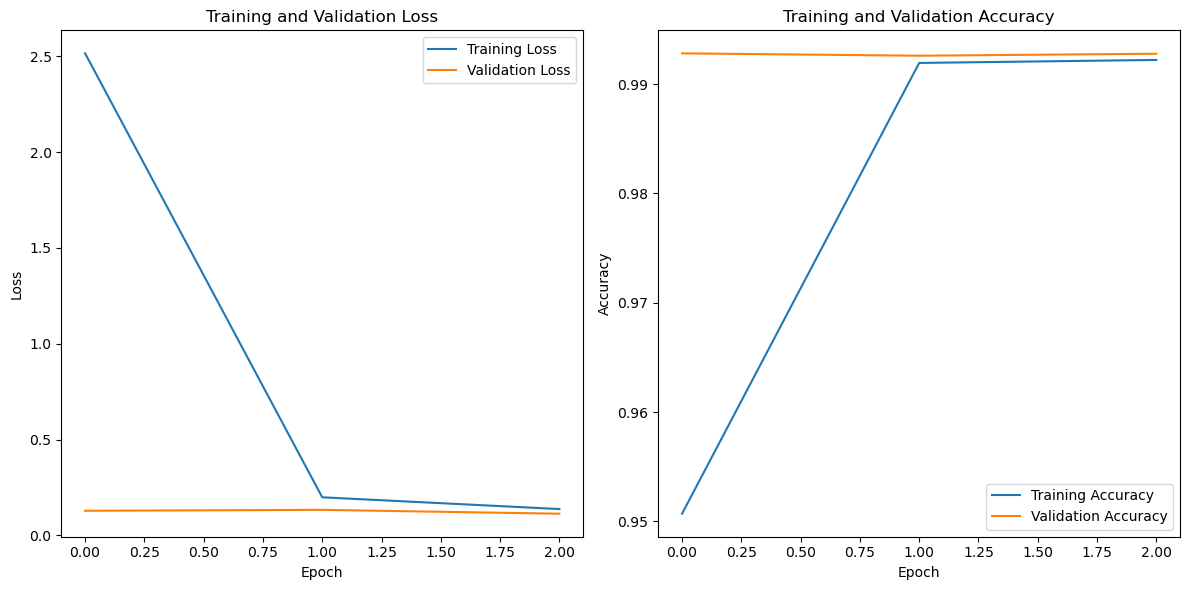

In [43]:
plot_training_history(history)

### 4. Model Evaluation

In [44]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate({'context': test_context_padded, 'question': test_question_padded}, 
                                          test_answer_padded)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

67/67 [==============================] - 129s 2s/step - loss: 0.1247 - accuracy: 0.9927
Test Loss: 0.12466416507959366, Test Accuracy: 0.9926772117614746


In [45]:
def predict_answer(context, question):
    # Preprocess the question and context
    preprocessed_question = preprocess_text(question)
    preprocessed_context = preprocess_text(context)

    # Tokenize and pad the sequences
    question_sequence = tokenizer.texts_to_sequences([preprocessed_question])
    context_sequence = tokenizer.texts_to_sequences([preprocessed_context])

    question_padded = pad_sequences(question_sequence, maxlen=max_seq_length, padding='post', truncating='post')
    context_padded = pad_sequences(context_sequence, maxlen=max_seq_length, padding='post', truncating='post')

    model_input = {'context': np.array(context_padded), 'question': np.array(question_padded)}
    predictions = model.predict(model_input)

    # obtain the index of the highest probability as the predicted answer index
    predicted_answer_index = np.argsort(predictions[0], axis=1)
    
    answer = []
    for idx in predicted_answer_index[0][-10:]:
        # Convert the index back to the word using the tokenizer
        predicted_answer = tokenizer.index_word.get(idx, 'unknown')
        answer.append(predicted_answer)
    
    return ' '.join(answer)

In [46]:
real_question = "What is the capital of France?"
given_context = "Paris is the capital of France."
predict_answer(given_context, real_question)

1/1 [==============================] - 1s 790ms/step


'2 japanese high 000 south british 1 half a the'

# Hyper-Parameter Tunning

Hyperparameters are external configuration settings that are not learned from the data but are set before the training process begins. 

In [47]:
# Define the hyperparameter search space
param_dist = {
    'lstm_units': [32, 64],
    'drop_rate': [0.25, 0.45],
    'embed_dim': [50, 100],
}

### Grid Search Technique

In [48]:
score_param_list = {'score': [], 'params': []}

for units in param_dist['lstm_units']:
    for rate in param_dist['drop_rate']:
        for dim in param_dist['embed_dim']:
            m = QAModel(vocab_size, embed_dim=dim, lstm_units=units, drop_rate=rate)
            m({'context': dummy_context, 'question': dummy_question})
            m.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

            history = m.fit({'context': train_context_padded, 'question': train_question_padded},
                              train_answer_padded, epochs=1, verbose=1, batch_size=16)
            
            score_param_list['score'].append(history.history)
            score_param_list['params'].append((dim, units, rate))

535/535 [==============================] - 758s 1s/step - loss: 1.9620 - accuracy: 0.9554


In [49]:
data = {'name': [], 'loss': [], 'accuracy': [], 'embedding_dimension': [], 'lstm_units': [], 'dropout_rate': []}
for idx in range(len(score_param_list['score'])):
    loss = np.round(score_param_list['score'][idx]['loss'][0], 3)
    accuracy = np.round(score_param_list['score'][idx]['accuracy'][0], 3)
    
    dim = score_param_list['params'][idx][0]
    unit = score_param_list['params'][idx][1]
    rate = score_param_list['params'][idx][2]
    
    data['name'].append(f"Model {idx + 1}")
    data['loss'].append(loss)
    data['accuracy'].append(accuracy)    
    data['embedding_dimension'].append(dim)    
    data['lstm_units'].append(unit)    
    data['dropout_rate'].append(rate)   
pd.DataFrame(data)

,name,loss,accuracy,embedding_dimension,lstm_units,dropout_rate
0,Model 1,2.582,0.967,50,32,0.25
1,Model 2,2.523,0.952,100,32,0.25
2,Model 3,2.648,0.964,50,32,0.45
3,Model 4,2.566,0.946,100,32,0.45
4,Model 5,2.037,0.974,50,64,0.25
5,Model 6,1.927,0.964,100,64,0.25
6,Model 7,2.095,0.975,50,64,0.45
7,Model 8,1.962,0.955,100,64,0.45


From above evaluation table after running grid-search, it is seen that Model 5 has the highest accuracy, and thus, the optimal choice of hyper-parameters would be embedding_dimension = 50, lstm_units = 32, and dropout_rate = 0.45.

In [50]:
score_param_list

{'score': [{'loss': [2.5815885066986084], 'accuracy': [0.9674561023712158]},
  {'loss': [2.5225472450256348], 'accuracy': [0.9516127705574036]},
  {'loss': [2.647794008255005], 'accuracy': [0.9637627601623535]},
  {'loss': [2.5656909942626953], 'accuracy': [0.9461934566497803]},
  {'loss': [2.037473201751709], 'accuracy': [0.9743645787239075]},
  {'loss': [1.9272840023040771], 'accuracy': [0.9636250734329224]},
  {'loss': [2.0952694416046143], 'accuracy': [0.9749109745025635]},
  {'loss': [1.962049126625061], 'accuracy': [0.9554476141929626]}],
 'params': [(50, 32, 0.25),
  (100, 32, 0.25),
  (50, 32, 0.45),
  (100, 32, 0.45),
  (50, 64, 0.25),
  (100, 64, 0.25),
  (50, 64, 0.45),
  (100, 64, 0.45)]}